In [1]:
import xupy as xp
import matplotlib.pyplot as plt
from ekarus.e2e.single_stage_ao_class import SingleStageAO
from ekarus.e2e.utils.image_utils import reshape_on_mask
from numpy.ma import masked_array


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
ssao = SingleStageAO('ristretto')
KL,_ = ssao.define_KL_modes(ssao.dm,zern_modes=2)
ssao.ccd.RON = 0

Initializing devices ...
Modulating 0 [lambda/D] with 0 modulation steps
Unobscured actuators: 1228/1240


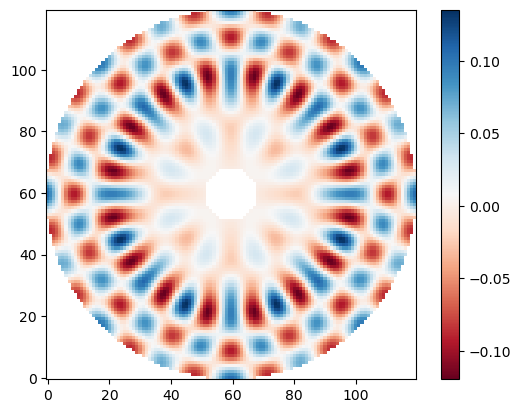

In [3]:
mode_id = 200
mode = KL[mode_id,:]
amp = 1e-8

m2rad = 2*xp.pi/ssao.pyr.lambdaInM
lambdaOverD = ssao.pyr.lambdaInM/ssao.pupilSizeInM
nPhotons = 1e+6

ef_amp = 1-ssao.cmask
in_ef = ef_amp * xp.exp(1j*reshape_on_mask(mode*amp*m2rad,ssao.cmask),dtype=xp.cfloat)

plt.figure()
plt.imshow(masked_array(xp.asnumpy(xp.angle(in_ef)),xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdBu')
plt.colorbar()

3186280.9110785467 2254.4220956619665


Text(0.5, 1.0, 'Throughput: 45%')

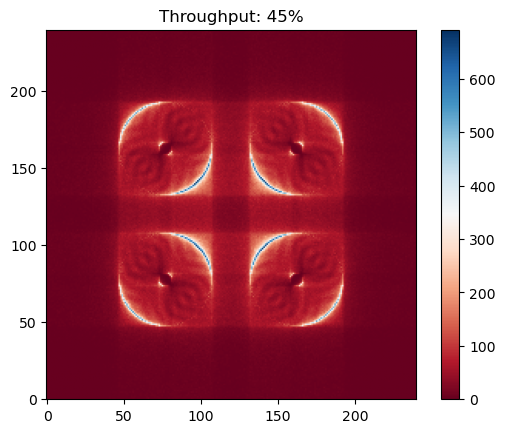

In [4]:
# Unmodulated case
# intensity = ssao.pyr.get_intensity(in_ef,lambda0OverD=lambdaOverD)
# image = ssao.ccd.image_on_detector(intensity, photon_flux=nPhotons)
push_slopes = ssao.sc.compute_slopes(in_ef,lambdaOverD=lambdaOverD,nPhotons=nPhotons)
pull_slopes = ssao.sc.compute_slopes(xp.conj(in_ef),lambdaOverD=lambdaOverD,nPhotons=nPhotons)
slopes = (push_slopes-pull_slopes)/amp
unmod_img = ssao.ccd.last_frame.copy()

unnorm_slopes = slopes*xp.mean(xp.hstack([unmod_img[~ssao.sc._roi_masks[i]] for i in range(4)]))/4

nPhotOut = xp.sum(xp.hstack([unmod_img[~ssao.sc._roi_masks[i]] for i in range(4)]))


flux = xp.sum(unmod_img)
thrp = nPhotOut/flux
snr = xp.std(unnorm_slopes)/xp.sqrt(flux)

print(snr,xp.std(unnorm_slopes)/flux)

plt.figure()
plt.imshow(xp.asnumpy(unmod_img),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title(f'Throughput: {thrp*1e+2:1.0f}%')

Modulating 0 [lambda/D] with 4 modulation steps
2391191.79921948 1691.2706843996343


Text(0.5, 1.0, 'Throughput: 58%')

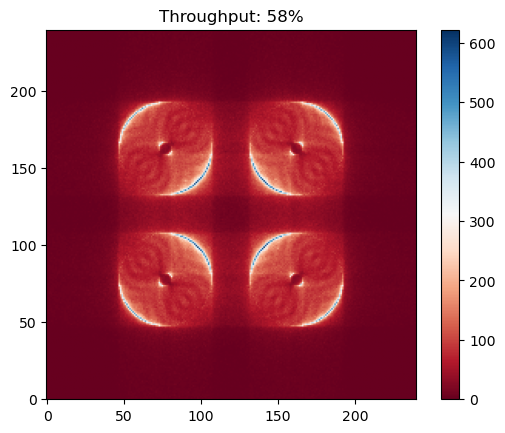

In [8]:
ssao.pyr.set_modulation_angle(0.5)

push_slopes = ssao.sc.compute_slopes(in_ef,lambdaOverD=lambdaOverD,nPhotons=nPhotons)
pull_slopes = ssao.sc.compute_slopes(xp.conj(in_ef),lambdaOverD=lambdaOverD,nPhotons=nPhotons)
slopes = (push_slopes-pull_slopes)/amp
mod_img = ssao.ccd.last_frame.copy()

unnorm_slopes = slopes*xp.mean(xp.hstack([unmod_img[~ssao.sc._roi_masks[i]] for i in range(4)]))/4

nPhotOut = xp.sum(xp.hstack([mod_img[~ssao.sc._roi_masks[i]] for i in range(4)]))

flux = xp.sum(mod_img)
slopes = ssao.sc.compute_slopes(in_ef,lambdaOverD=lambdaOverD,nPhotons=nPhotons)
thrp = nPhotOut/flux
snr = xp.std(unnorm_slopes)/xp.sqrt(flux)

print(snr,xp.std(unnorm_slopes)/flux)

plt.figure()
plt.imshow(xp.asnumpy(mod_img),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title(f'Throughput: {thrp*1e+2:1.0f}%')